In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
from linear_mcmc import *

from redTools import *
from Kcorrect import *
from calibTools import *

In [2]:
table   = np.genfromtxt('corrected_mags_linewidth_all.csv' , delimiter='|', 
                        filling_values=-1, names=True, dtype=None, encoding=None)
pgc = table['pgc']

print len(pgc)

10736


In [3]:
## this slope comes from a fit to all clusters
slope = -8.33
band = 'i'
zp_calibs = all_ZP(table, band=band, slope=slope)

N = len(zp_calibs['pgc'])
print N
# for i in range(N):
#     print zp_calibs['pgc'][i], zp_calibs['ID'][i], zp_calibs['dist'][i]

108
56


-8.33 -20.841074393853813


Text(1.548,-21.6,'ZP = -20.84$\\pm$0.08')

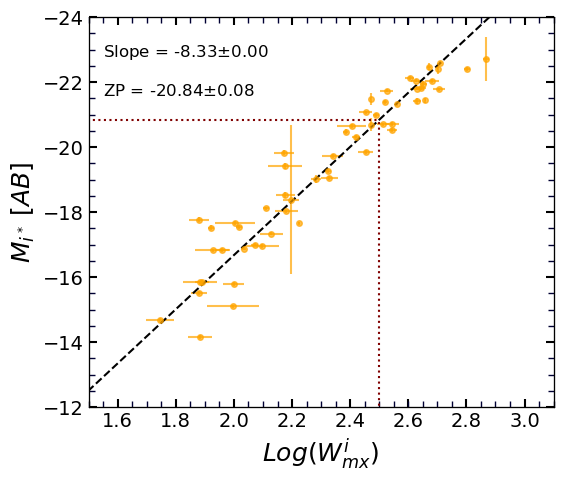

In [4]:
fig, ax = makeFig(band=band, xLim = (1.5,3.1), yLim = (-12,-24), MAGabs=True)
plotCluster(ax, zp_calibs, offset=0, plotErrors=True, alpha=0.7, markersize=0, plotFit=True)

m0 = zp_calibs['slope']
b0 = zp_calibs['zp']
dm0 = zp_calibs['slope_e']
db0 = zp_calibs['zp_e']
mag_ = zp_calibs['MAG']
logWimx_ = zp_calibs['logWimx']
pgc_ = zp_calibs['pgc']

print m0, b0

Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
x0 = 0.97*Xlm[0]+0.03*Xlm[1]
y0 = 0.1*Ylm[0]+0.90*Ylm[1]
ax.text(x0,y0, "Slope = "+"%.2f" % m0+'$\pm$'+"%.2f" % dm0, fontsize=12, color='k')
y0 = 0.2*Ylm[0]+0.80*Ylm[1]
ax.text(x0,y0, "ZP = "+"%.2f" % b0+'$\pm$'+"%.2f" % db0, fontsize=12, color='k')

In [5]:
from bokeh.plotting import *
from bokeh.embed import components
from bokeh.models import ColumnDataSource, LabelSet, HoverTool, Range1d, Label, TapTool, OpenURL, CustomJS, CrosshairTool

output_notebook()

Loading BokehJS ...

In [6]:
if True:
    
    hover = HoverTool(tooltips=[ 
        ("LogWimx", "@LogWimx"),
        (band, "@"+band),
        ("PGC", "@PGC"),
        ])

    hover.point_policy='snap_to_data'
    hover.line_policy='nearest'#'prev'

    TOOLS = ['pan', 'tap', 'wheel_zoom', 'box_zoom', 'reset', 'save']

    p = figure(tools=TOOLS, toolbar_location="below", plot_width=550, plot_height=450)
    p.title.text_font_size = '14pt'
    p.title.text_color = 'green'
    p.grid.grid_line_color="gainsboro"
    dye = {"u":"blue","g":"green","r":"red","i":"orange","z":"maroon","w1":"purple", 'w2': "brown"}
    rang=dye[band] 

    source = ColumnDataSource({'LogWimx': logWimx_, band: mag_, 'PGC': pgc_})
    render = p.circle('LogWimx', band, source=source, size=5, color=rang, alpha=0.7, hover_color='red', hover_alpha=1, hover_line_color='red',
                        
                        # set visual properties for selected glyphs
                        selection_fill_color=rang,

                        # set visual properties for non-selected glyphs
                        nonselection_fill_alpha=1,
                        nonselection_fill_color=rang,)
    
    x = np.linspace(-5,5,50)
    p.line(x, m0*(x-2.5)+b0, line_width=1, color="black", line_dash='dashed')
    p.legend.location = "top_right"

    p.x_range = Range1d(1.5,3.1)
    p.y_range = Range1d(-12,-24)

    p.xaxis.axis_label = 'Log(W^i_mx)'
    p.yaxis.axis_label = band+'* [mag]'
    p.xaxis.axis_label_text_font_size = "14pt"
    p.yaxis.axis_label_text_font_size = "14pt"
    p.grid.grid_line_color="gainsboro"
    p.yaxis.major_label_text_font_size = "12pt"
    p.xaxis.major_label_text_font_size = "12pt"
    
    
    code = """
        
        var index_selected = source.selected['1d']['indices'][0];
        var win = window.open("http://edd.ifa.hawaii.edu/cf4_photometry/get_sdss_cf4.php?pgc="+source.data['PGC'][index_selected]+"#t01", "EDDesn", "width=1200, height=1000");
        try {win.focus();} catch (e){}

    """

    taptool = p.select(type=TapTool)
    taptool.callback = CustomJS(args=dict(source=source), code=code)



    ttp = """
        <div>
            <div>
                <span style="font-size: 16px; color: blue;">PGC:</span>
                <span style="font-size: 16px; font-weight: bold;">@PGC{int}</span>
            </div>
            <div>
                <span style="font-size: 16px; color: blue;">LogWimx:</span>
                <span style="font-size: 16px; font-weight: bold;">@LogWimx</span>
            </div>  
            <div>
                <span style="font-size: 16px; color: blue;">"""+band+""":</span>
                <span style="font-size: 16px; font-weight: bold;">@"""+band+"""{0.2f}</span>
            </div>          
        </div>
    """


    hover = HoverTool(tooltips=ttp, renderers=[render])

    hover.point_policy='snap_to_data'
    hover.line_policy='nearest'
    #hover.mode='vline'
    p.add_tools(hover)   

    cross = CrosshairTool()
    #cross.dimensions='height'
    cross.line_alpha = 0.3
    cross.line_color = 'green'
    p.add_tools(cross)     

    mytext = Label(x=20, y=290, text="Slope= "+"%.2f" % m0+'+-'+"%.2f" % dm0, text_color='black', text_font_size='12pt', x_units='screen', y_units='screen')
    p.add_layout(mytext)
    mytext = Label(x=20, y=260, text="ZP= "+"%.2f" % b0+'+-'+"%.2f" % db0, text_color='black', text_font_size='12pt', x_units='screen', y_units='screen')
    p.add_layout(mytext)    
    
    show(p)